# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Traffic Sign Recognition Classifier


---
## Step 0: Data Loading

In [27]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


### Basic Summary of the Data Set

In [28]:
# load sing names csv
import pandas as pd

sign_names_df = pd.read_csv("signnames.csv")
sign_names=[]
for i,r in sign_names_df.iterrows():
    sign_names.append(r['SignName'])

In [29]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_valid = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(sign_names)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [30]:
import PIL.Image
from io import StringIO
from io import BytesIO
import IPython.display

def showArray(a, fmt='png', concat=False, normalized=False):
    """Display an array image RAW without any resizing. If a is an array of images and concat=True, images are concatenated horizontally."""
    if concat:
        cimages = []
        for i in a:
            if not len(cimages):
                cimages=i
                continue
            cimages = np.concatenate((cimages,i),axis=1)
        a = cimages
    
    if normalized:
        a = a * 255
        
    if a.ndim==2:
        a=np.uint8(a)
    elif a.ndim==3 and a.shape[2]==3:
        pass
    else:
        raise Exception('only 2d and 3d arrays with 3 colors supported')
    
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

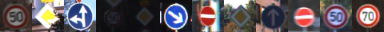

In [24]:
import random
import numpy as np
temp=[]
for i in range(12):
    temp.append(X_train[random.randrange(len(X_train))])
showArray(temp,concat=True)

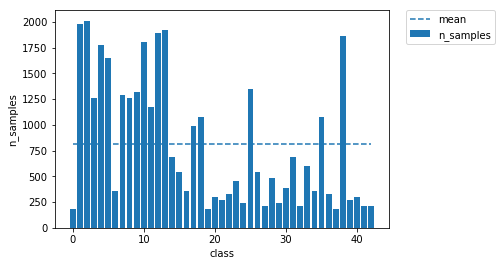

total samples      : 34799
max samples/class  : 2010
min samples/class  : 180
mean samples/class : 809.279069767


In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

classes_id, classes_first_index, classes_count = np.unique(y_train, return_counts=True, return_index=True)
classes_count_mean = [np.mean(classes_count) for i in classes_count]

#print(classes_unique)
#print(classes_indexes)
#print(classes_counts)

fig,ax = plt.subplots()
ax.bar(np.arange(classes_count.size), classes_count, label='n_samples')
ax.plot(np.arange(classes_count.size), classes_count_mean, label='mean', linestyle='--')
ax.set_xlabel('class')
ax.set_ylabel('n_samples')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print('total samples      :',np.sum(classes_count))
print('max samples/class  :',np.max(classes_count))
print('min samples/class  :',np.min(classes_count))
print('mean samples/class :',np.mean(classes_count))

### List of possible image filters and transformations for normalizing and augmenting the data set

--- test image ---


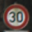

--- rgb2L ---


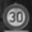

--- flip horizontal ---


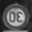

--- flip vertical ---


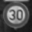

--- rotate 180 ---


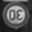

--- rotate random ---


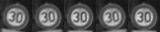

--- scale random ---


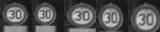

--- project random ---


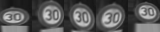

--- equalize histogram ---


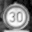

--- equalize clahe ---
       clipLimit range(1,32,2)


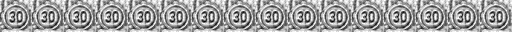

       tileSize range(1,32,2)


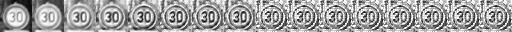

--- equalize adaptive histogram ---


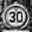

--- median range(0,6) ---


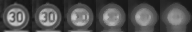

--- threshold_local range(1,10,2) ---


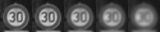

--- random noise ---


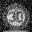

In [33]:
import numpy as np
import skimage.transform
import skimage.morphology
import skimage.exposure
import skimage.filters.rank
import random
import warnings
import cv2

def img_rgb2LNorm(img):
    labImg = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    labImg = labImg[:,:,0]
    return labImg/255.
    
def img_flip_vertical(img):
    return np.flipud(img)

def img_flip_horizontal(img):
    return np.fliplr(img)

def img_rotate_180(img):
    return img_flip_vertical(img_flip_horizontal(img))

def img_rotate_120(img):
    return skimage.transform.rotate(img, 120, mode='edge')

def img_rotate_240(img):
    return skimage.transform.rotate(img, 240, mode='edge')

def img_rotate_random(img, degrees=5):
    """ random rotation between degrees cw and degrees ccw """
    return skimage.transform.rotate(img, random.uniform(-degrees,degrees), mode='edge')

def img_scale_random(img, scale_diff=0.2):
    transform = skimage.transform.AffineTransform(scale=(random.uniform(1.0-scale_diff, 1.0+scale_diff),random.uniform(1.0-scale_diff, 1.0+scale_diff)))
    img = skimage.transform.warp(img, transform.inverse, mode='edge')
    return(img)

def img_quadmap_random(img, max_distance=5):
    """ quadmap transformation, moving each corner max_distance pixels from original """
    w=img.shape[0]
    h=img.shape[1]
    matrix = np.array(((0,0),(0,h),(w,h),(w,0)))
    projection = skimage.transform.ProjectiveTransform()
    projection.estimate(matrix+(2.*np.random.rand(matrix.size).reshape(matrix.shape)-1)*max_distance,matrix)
    img = skimage.transform.warp(img, projection, mode='edge')
    return(img)

def img_equalize_hist(img):
    return cv2.equalizeHist((img*255).astype(np.uint8))/255.

def img_equalize_clahe(img, clipLimit=4, tileSize=14):
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(tileSize,tileSize))
    return clahe.apply((img*255).astype(np.uint8))/255.      

def img_equalize_adapthist(img):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = skimage.exposure.equalize_adapthist(img)
    return(img)

def img_median(img, size=5):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = 1-skimage.filters.rank.median(img, skimage.morphology.disk(size))
    return(img)

def img_threshold_local(img, size=5):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = skimage.filters.threshold_local(img, size, method='gaussian')
    return(img)

def img_random_noise(img):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = skimage.util.random_noise(img)
    return(img)

def imgTransformTests():
    testImg = X_train[3324]
    
    print("--- test image ---")
    showArray(testImg)

    testImgL = img_rgb2LNorm(testImg) 
    print("--- rgb2L ---")
    showArray(testImgL, normalized=True)
    
    print("--- flip horizontal ---")
    showArray(img_flip_horizontal(testImgL), normalized=True)

    print("--- flip vertical ---")
    showArray(img_flip_vertical(testImgL), normalized=True)

    print("--- rotate 180 ---")
    showArray(img_rotate_180(testImgL), normalized=True)

    print("--- rotate random ---")
    temp=[]
    for i in range(5):
        temp.append(img_rotate_random(testImgL,11))
    showArray(temp,concat=True, normalized=True)
    
    print("--- scale random ---")
    temp=[]
    for i in range(5):
        temp.append(img_scale_random(testImgL))
    showArray(temp,concat=True, normalized=True)
        
    print("--- project random ---")
    temp=[]
    for i in range(5):
        temp.append(img_quadmap_random(testImgL, 7))
    showArray(temp,concat=True, normalized=True)
    
    print("--- equalize histogram ---")
    showArray(img_equalize_hist(testImgL), normalized=True)

    print("--- equalize clahe ---")
    print("       clipLimit range(1,32,2)")
    temp=[]
    for i in range(1,32,2):
        temp.append(img_equalize_clahe(testImgL,i,14))
    showArray(temp, concat=True, normalized=True)
    print("       tileSize range(1,32,2)")
    temp=[]
    for i in range(1,32,2):
        temp.append(img_equalize_clahe(testImgL,4,i))
    showArray(temp, concat=True, normalized=True)

    print("--- equalize adaptive histogram ---")
    showArray(img_equalize_adapthist(testImgL), normalized=True)
    
    print("--- median range(0,6) ---")
    temp=[]
    for i in range(0,6):
        temp.append(img_median(testImgL,i))
    showArray(temp, concat=True, normalized=True)

    print("--- threshold_local range(1,10,2) ---")
    temp=[]
    for i in range(1,10,2):
        temp.append(img_threshold_local(testImgL,i))
    showArray(temp, concat=True, normalized=True)
    
    print("--- random noise ---")
    showArray(img_random_noise(testImgL), normalized=True)
    
imgTransformTests()


### List of classes

Images are converted to CIE Lab color space. L channel is extracted, a and b channels discarded, then the L channel is normalized with adaptive histogram filter.

uint8
class: 0   -  count: 180   -  name: Speed limit (20km/h)


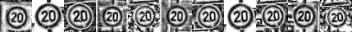

------------------------
class: 1   -  count: 1980   -  name: Speed limit (30km/h)


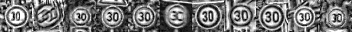

------------------------
class: 2   -  count: 2010   -  name: Speed limit (50km/h)


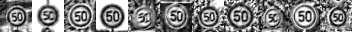

------------------------
class: 3   -  count: 1260   -  name: Speed limit (60km/h)


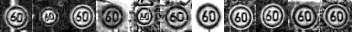

------------------------
class: 4   -  count: 1770   -  name: Speed limit (70km/h)


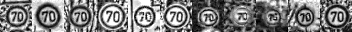

------------------------
class: 5   -  count: 1650   -  name: Speed limit (80km/h)


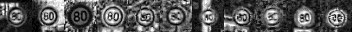

------------------------
class: 6   -  count: 360   -  name: End of speed limit (80km/h)


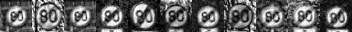

------------------------
class: 7   -  count: 1290   -  name: Speed limit (100km/h)


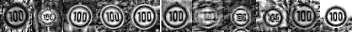

------------------------
class: 8   -  count: 1260   -  name: Speed limit (120km/h)


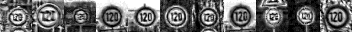

------------------------
class: 9   -  count: 1320   -  name: No passing


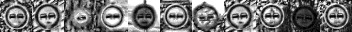

------------------------
class: 10   -  count: 1800   -  name: No passing for vehicles over 3.5 metric tons


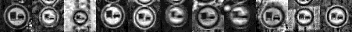

------------------------
class: 11   -  count: 1170   -  name: Right-of-way at the next intersection


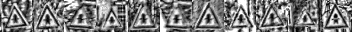

------------------------
class: 12   -  count: 1890   -  name: Priority road


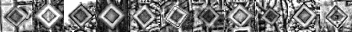

------------------------
class: 13   -  count: 1920   -  name: Yield


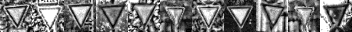

------------------------
class: 14   -  count: 690   -  name: Stop


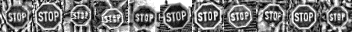

------------------------
class: 15   -  count: 540   -  name: No vehicles


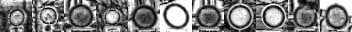

------------------------
class: 16   -  count: 360   -  name: Vehicles over 3.5 metric tons prohibited


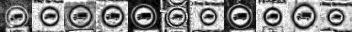

------------------------
class: 17   -  count: 990   -  name: No entry


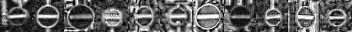

------------------------
class: 18   -  count: 1080   -  name: General caution


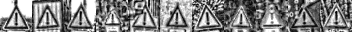

------------------------
class: 19   -  count: 180   -  name: Dangerous curve to the left


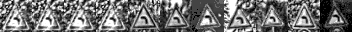

------------------------
class: 20   -  count: 300   -  name: Dangerous curve to the right


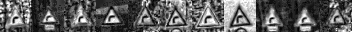

------------------------
class: 21   -  count: 270   -  name: Double curve


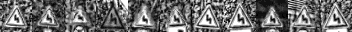

------------------------
class: 22   -  count: 330   -  name: Bumpy road


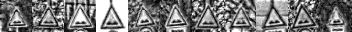

------------------------
class: 23   -  count: 450   -  name: Slippery road


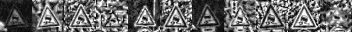

------------------------
class: 24   -  count: 240   -  name: Road narrows on the right


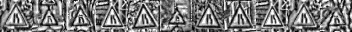

------------------------
class: 25   -  count: 1350   -  name: Road work


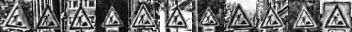

------------------------
class: 26   -  count: 540   -  name: Traffic signals


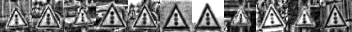

------------------------
class: 27   -  count: 210   -  name: Pedestrians


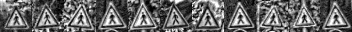

------------------------
class: 28   -  count: 480   -  name: Children crossing


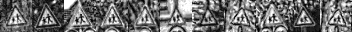

------------------------
class: 29   -  count: 240   -  name: Bicycles crossing


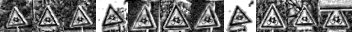

------------------------
class: 30   -  count: 390   -  name: Beware of ice/snow


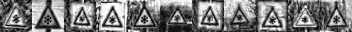

------------------------
class: 31   -  count: 690   -  name: Wild animals crossing


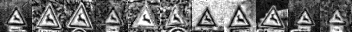

------------------------
class: 32   -  count: 210   -  name: End of all speed and passing limits


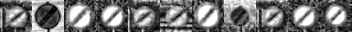

------------------------
class: 33   -  count: 599   -  name: Turn right ahead


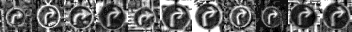

------------------------
class: 34   -  count: 360   -  name: Turn left ahead


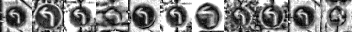

------------------------
class: 35   -  count: 1080   -  name: Ahead only


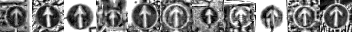

------------------------
class: 36   -  count: 330   -  name: Go straight or right


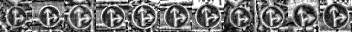

------------------------
class: 37   -  count: 180   -  name: Go straight or left


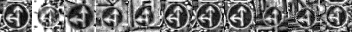

------------------------
class: 38   -  count: 1860   -  name: Keep right


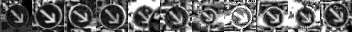

------------------------
class: 39   -  count: 270   -  name: Keep left


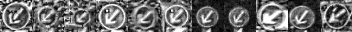

------------------------
class: 40   -  count: 300   -  name: Roundabout mandatory


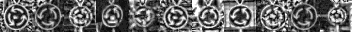

------------------------
class: 41   -  count: 210   -  name: End of no passing


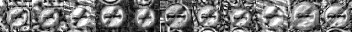

------------------------
class: 42   -  count: 210   -  name: End of no passing by vehicles over 3.5 metric tons


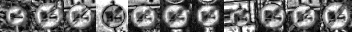

------------------------


In [34]:
import cv2
from skimage import exposure
import warnings

def rgb2Lab(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

print(X_train.dtype)

for c_id, c_index, c_count in zip(classes_id, classes_first_index, classes_count):
    print('class:',c_id,'  -  count:',c_count,'  -  name:',sign_names[c_id])
    #print(c_id, c_index, c_count)
    temp=[]
    for i in np.random.randint(c_index, high=c_index+c_count, size=11):
        labImg = rgb2Lab(X_train[i])
        labImg = labImg[:,:,0]
                
        #skimage adapthist
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            skeq_img = img_equalize_adapthist(labImg)
            
        #temp.append(X_train[i])
        temp.append(skeq_img*255)
                
    showArray(temp,concat=True)
    print('------------------------')

## Step 2: Preprocess Data Set, Augment and Normalize 

### Convert images to grayscale/equalize

Convert RGB images to CIELab color space. Extract the L channel, discard color channels (ab).
Apply adaptive histogram equalization.

In [11]:
def preprocess_data(X_train, X_valid, X_test):
    """convert input images to Lab color model, extract L channel (discard ab) and apply equalization"""

    X_train_norm = np.array([img_equalize_adapthist(img_rgb2LNorm(xi)) for xi in X_train])[:,:,:,None]
    X_valid_norm = np.array([img_equalize_adapthist(img_rgb2LNorm(xi)) for xi in X_valid])[:,:,:,None]
    X_test_norm = np.array([img_equalize_adapthist(img_rgb2LNorm(xi)) for xi in X_test])[:,:,:,None]


    return (X_train_norm, X_valid_norm, X_test_norm)

### Augment image data by flipping/rotating images

Some classes can be flipped/rotated to create additional training data. For example the **Yield** sign (#13) can be flipped horizontally, or the **Dangerous Curve Left** sign (#19) can be flipped horizontally and create a new **Dangerous Curve Right** sign (#20).

In [12]:
def flip_rotate(x, y, fn, src_class, dst_class, classes_id, classes_first_index, classes_count):
    if not classes_id[src_class]==src_class:
        raise Exception("class id doesn't match class_id position")

    new_images = []
    for i in range(classes_first_index[src_class], classes_first_index[src_class]+classes_count[src_class]):
        img = fn(x[i])
        if not len(new_images):
            new_images = img[None,:]
        else:
            new_images=np.append(new_images,img[None,:],axis=0)

    new_ids = np.full(classes_count[src_class],dst_class)

    x=np.concatenate((x,new_images),axis=0)
    y=np.concatenate((y,new_ids),axis=0)

    return(x,y)

def augment_flip_rotate(x,y):
    classes_id, classes_first_index, classes_count = np.unique(y, return_counts=True, return_index=True)
    # plt.bar(np.arange(classes_count.size), classes_count, label='n_samples')
    # plt.show()
    for i in (1,5,12,15,17):
        x,y=flip_rotate(x, y, img_flip_vertical, i, i, classes_id, classes_first_index, classes_count)
    for i in (11,12,13,15,17,18,22,26,30,35):
        x,y=flip_rotate(x, y, img_flip_horizontal, i, i, classes_id, classes_first_index, classes_count)
    for i in (12,15,17,32):
        x,y=flip_rotate(x, y, img_rotate_180, i, i, classes_id, classes_first_index, classes_count)
    for i,ii in ((19,20),(33,34),(36,37),(38,39)):
        x,y=flip_rotate(x, y, img_flip_horizontal, i, ii, classes_id, classes_first_index, classes_count)
    for i in [40]:
        x,y=flip_rotate(x, y, img_rotate_120, i, i, classes_id, classes_first_index, classes_count)
        x,y=flip_rotate(x, y, img_rotate_240, i, i, classes_id, classes_first_index, classes_count)


    # sort x and y based on y
    p = y.argsort()
    x=x[p]
    y=y[p]

    classes_id, classes_first_index, classes_count = np.unique(y, return_counts=True, return_index=True)
#     plt.bar(np.arange(classes_count.size), classes_count, label='n_samples')
#     plt.show()
    return(x,y)


### Augment training data by applying filters

Images are randomly rotated, scaled and morphed by moving the four corners to create additional training data. At the end of the filter augmentation, all classes have the same amount of images.

In [30]:
import random

def augment_filter_class(x, y, c_id, c_index, c_count, aug_count):
    #print("filter augment:",c_id, c_index, c_count, aug_count)

    if aug_count==0:
        return x,y

    new_images = []
    for i in range(aug_count):
        src_index = random.randrange(c_index, c_index+c_count)

        img = x[src_index]

        img = img_quadmap_random(img, max_distance=random.randrange(1,7))           
        img = img_rotate_random(img, degrees=random.randrange(0,10))                
        img = img_scale_random(img, scale_diff=random.uniform(0,0.2))               

        if not len(new_images):
            new_images = img[None,:]
        else:
            new_images=np.append(new_images,img[None,:],axis=0)

    new_ids = np.full(aug_count,c_id)

    x=np.concatenate((x,new_images),axis=0)
    y=np.concatenate((y,new_ids),axis=0)

    return x,y

def augment_filter(x,y,max_samples=-1):
    """if max_sample==-1, augment to largest class count"""
    classes_id, classes_first_index, classes_count = np.unique(y, return_counts=True, return_index=True)
    if max_samples==-1:
        max_samples = np.max(classes_count)
    for c_id, c_index, c_count in zip (classes_id, classes_first_index, classes_count):
        aug_count = max_samples - c_count
        x,y=augment_filter_class(x, y, c_id, c_index, c_count, aug_count)

    return(x,y)

### Utility functions for saving/loading data

In [35]:
_data_path = './traffic-signs-data'
_data_prefix = 'jupyter'

def save_data(path, prefix, X_train, X_valid, X_test, y_train, y_valid, y_test):
    print('Saving preprocessed training data with prefix:',prefix)
    with open('{}/{}_train.p'.format(path,prefix), 'wb') as handle:
        pickle.dump({'features':X_train, 'labels':y_train}, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('{}/{}_valid.p'.format(path,prefix), 'wb') as handle:
        pickle.dump({'features':X_valid, 'labels':y_valid}, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('{}/{}_test.p'.format(path,prefix), 'wb') as handle:
        pickle.dump({'features':X_test, 'labels':y_test}, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_data(path, prefix):
    with open('{}/{}_train.p'.format(path, prefix), 'rb') as handle:
        train = pickle.load(handle)
    with open('{}/{}_valid.p'.format(path, prefix), 'rb') as handle:
        valid = pickle.load(handle)
    with open('{}/{}_test.p'.format(path, prefix), 'rb') as handle:
        test = pickle.load(handle)
    X_train, y_train = train['features'], train['labels']
    X_valid, y_valid = valid['features'], valid['labels']
    X_test, y_test = test['features'], test['labels']
    return(X_train, X_valid, X_test, y_train, y_valid, y_test)

------------------------
Data set with L (lightness) extracted and images equalized:
X_train shape: (34799, 32, 32, 1) (34799,)


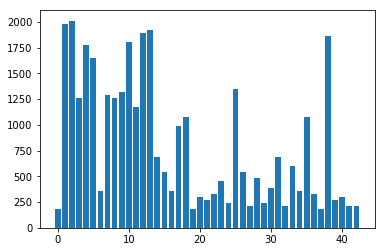

In [25]:
# convert to L and equalize
#
X_train, X_valid, X_test = preprocess_data(X_train, X_valid, X_test)
print('------------------------')
print('Data set with L (lightness) extracted and images equalized:')
print("X_train shape:", X_train.shape,y_train.shape)
classes_id, classes_first_index, classes_count = np.unique(y_train, return_counts=True, return_index=True)
plt.bar(np.arange(classes_count.size), classes_count, label='n_samples')
plt.show()

------------------------
Augmented data set by flipping and rotating:
X_train shape: (58978, 32, 32, 1) (58978,)


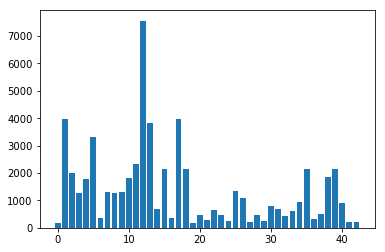

In [26]:
#flip rotate augment
#
X_train,y_train = augment_flip_rotate(X_train,y_train)

print('------------------------')
print('Augmented data set by flipping and rotating:')
print("X_train shape:", X_train.shape,y_train.shape)
classes_id, classes_first_index, classes_count = np.unique(y_train, return_counts=True, return_index=True)
plt.bar(np.arange(classes_count.size), classes_count, label='n_samples')
plt.show()

------------------------
Augmented data set by filters and transformations:
X_train shape: (325080, 32, 32, 1) (325080,)


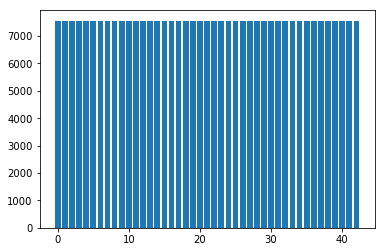

In [31]:
#filter augment
#
X_train,y_train = augment_filter(X_train,y_train)

print('------------------------')
print('Augmented data set by filters and transformations:')
print("X_train shape:", X_train.shape,y_train.shape)
classes_id, classes_first_index, classes_count = np.unique(y_train, return_counts=True, return_index=True)
plt.bar(np.arange(classes_count.size), classes_count, label='n_samples')
plt.show()

In [35]:
# save processed data
save_data(_data_path,_data_prefix,X_train, X_valid, X_test, y_train, y_valid, y_test)

Saving preprocessed training data with prefix: jupyter


----

## Step 2: Design and Test a Model Architecture



### Convenience functions for creating model

In [36]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np

def convolution_relu(input, K=5, S=1, D=16, padding='SAME'):
    # W1 x H1 x D1 input
    # K number of filters
    # F spatial intent (size)
    # S stride
    # P padding
    # W2 = (W1−F+2P)/S+1
    # H2 = (H1−F+2P)/S+1
    # D2 = K

    input_w = input.shape[1]
    input_h = input.shape[2]
    input_d = 1
    if len(input.shape)==4:
        input_d = input.shape[3]

    weights = tf.get_variable('weights', shape=[K,K,input_d,D], initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[D], initializer = tf.zeros_initializer())

    output = tf.nn.conv2d(input, weights, strides=[1,S,S,1], padding=padding)
    output = tf.nn.bias_add(output, biases)

    output = tf.nn.relu(output)
    return output

def pool(input, k_size):
    return tf.nn.max_pool(input, [1, k_size, k_size, 1], [1, k_size, k_size, 1], padding='SAME')

def dropout(input, keep_prob=0.5):
    return tf.nn.dropout(input, keep_prob)

def fully_connected(input, n_output):
    input_w = int(input.get_shape()[1])
    weights = tf.get_variable('weights', shape=[input_w, n_output], initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[n_output], initializer = tf.zeros_initializer())
    return tf.add(tf.matmul(input, weights), biases)

def fully_connected_relu(input, n_output):
    return tf.nn.relu(fully_connected(input, n_output))

def get_scope_variable(scope_name, var_name):
    with tf.variable_scope(scope_name, reuse=True):
        v = tf.get_variable(var_name)
    return v


### Model Architecture

In [37]:
def build_model(x, enable_dropout, config):
    _=config
    k, fcr1_size, fcr2_size, cr1_d, cr2_d, cr3_d, cr4_d = (_['k'],_['fcr1_size'],_['fcr2_size'],_['cr1_d'],_['cr2_d'],_['cr3_d'],_['cr4_d'])
    cr1_drop, cr2_drop, cr3_drop, cr4_drop, fcr1_drop, fcr2_drop = (_['cr1_drop'], _['cr2_drop'], _['cr3_drop'], _['cr4_drop'], _['fcr1_drop'], _['fcr2_drop'])

    with tf.variable_scope('cr1'):
        cr1 = convolution_relu(x, K=k, S=1, D=cr1_d, padding='SAME')
        print('cr1 shape:', cr1.shape)
        cr1 = pool(cr1, 2)
        cr1 = tf.cond(enable_dropout, lambda: dropout(cr1, keep_prob=cr1_drop), lambda: cr1)

    with tf.variable_scope('cr2'):
        cr2 = convolution_relu(cr1, K=k, S=1, D=cr2_d, padding='SAME')
        print('cr2 shape:', cr2.shape)
        cr2 = pool(cr2, 2)
        cr2 = tf.cond(enable_dropout, lambda: dropout(cr2, keep_prob=cr2_drop), lambda: cr2)

    with tf.variable_scope('cr3'):
        cr3 = convolution_relu(cr2, K=k, S=1, D=cr3_d, padding='SAME')
        print('cr3 shape:', cr3.shape)
        cr3 = pool(cr3, 2)
        cr3 = tf.cond(enable_dropout, lambda: dropout(cr3, keep_prob=cr3_drop), lambda: cr3)

    with tf.variable_scope('cr4'):
        cr4 = convolution_relu(cr3, K=k, S=1, D=cr4_d, padding='SAME')
        print('cr4 shape:', cr4.shape)
        cr4 = pool(cr4, 2)
        cr4 = tf.cond(enable_dropout, lambda: dropout(cr4, keep_prob=cr4_drop), lambda: cr4)

    flat = tf.concat((flatten(cr1),flatten(cr2),flatten(cr3),flatten(cr4)),1)
    print('flat shape:', flat.shape)

    with tf.variable_scope('fcr1'):
        fcr1 = fully_connected_relu(flat, fcr1_size)
        print('fcr1 shape:', fcr1.shape)
        fcr1 = tf.cond(enable_dropout, lambda: dropout(fcr1, keep_prob=fcr1_drop), lambda: fcr1)

    with tf.variable_scope('fcr2'):
        fcr2 = fully_connected_relu(fcr1, fcr2_size)
        print('fcr2 shape:', fcr2.shape)
        fcr2 = tf.cond(enable_dropout, lambda: dropout(fcr2, keep_prob=fcr2_drop), lambda: fcr2)

    with tf.variable_scope('fc3'):
        fc3 = fully_connected(fcr2, 43)
        print('fc3 shape:', fc3.shape)

    logits = fc3

    return(logits)

### Train, Validate and Test the Model

In [61]:
BATCH_SIZE = 256
SESSION_FOLDER = './train-sessions-jupyter'
SESSION_PATH = './train-sessions-jupyter/session'

# config parameters
_c =  { 'epochs':64, 'learn_rate':0.0007, 'k':3, 'fcr1_size':4096, 'fcr2_size':1024, 'cr1_d':64, 'cr2_d':128, 'cr3_d':256, 'cr4_d':512, 'cr1_drop':0.6, 'cr2_drop':0.5, 'cr3_drop':0.6,'cr4_drop':0.6, 'fcr1_drop':0.6, 'fcr2_drop':0.7 }

X_train, X_valid, X_test, y_train, y_valid, y_test = load_data(_data_path,_data_prefix)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

image_shape = X_train[0].shape
image_w = image_shape[0]
image_h = image_shape[1]
classes_id, classes_first_index, classes_count = np.unique(y_train, return_counts=True, return_index=True)
n_classes=classes_id.size

tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, image_w, image_h, 1))
y = tf.placeholder(tf.int32, (None))
enable_dropout = tf.placeholder(tf.bool)
y_one_hot = tf.one_hot(y, n_classes)

logits = build_model(x,enable_dropout, _c)

fcr1_weights = get_scope_variable('fcr1', 'weights')
fcr2_weights = get_scope_variable('fcr2', 'weights')
fc3_weights = get_scope_variable('fc3', 'weights')

l2_weights = [fcr1_weights, fcr2_weights, fc3_weights]

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_one_hot, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)

for w in l2_weights:
    loss_operation = loss_operation + 0.0001*tf.nn.l2_loss(w)

optimizer = tf.train.AdamOptimizer(learning_rate = _c['learn_rate'])
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        correct, accuracy = sess.run((correct_prediction, accuracy_operation), feed_dict={x: batch_x, y: batch_y, enable_dropout: False})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


validation_log = []
train_time = 0
test_accuracy=0

import time
start_time = time.time()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(_c['epochs']):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, enable_dropout: True})

        validation_accuracy = evaluate(X_valid, y_valid)
        validation_log.append(validation_accuracy)

        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    train_time = time.time() - start_time
    print("--- training: %s seconds ---" % (time.time() - start_time))

    saver.save(sess, SESSION_PATH)
    print("Model saved")



cr1 shape: (?, 32, 32, 64)
cr2 shape: (?, 16, 16, 128)
cr3 shape: (?, 8, 8, 256)
cr4 shape: (?, 4, 4, 512)
flat shape: (?, 30720)
fcr1 shape: (?, 4096)
fcr2 shape: (?, 1024)
fc3 shape: (?, 43)
Training...

EPOCH 1 ...
Validation Accuracy = 0.920

EPOCH 2 ...
Validation Accuracy = 0.974

EPOCH 3 ...
Validation Accuracy = 0.983

EPOCH 4 ...
Validation Accuracy = 0.983

EPOCH 5 ...
Validation Accuracy = 0.984

EPOCH 6 ...
Validation Accuracy = 0.988

EPOCH 7 ...
Validation Accuracy = 0.986

EPOCH 8 ...
Validation Accuracy = 0.987

EPOCH 9 ...
Validation Accuracy = 0.988

EPOCH 10 ...
Validation Accuracy = 0.988

EPOCH 11 ...
Validation Accuracy = 0.989

EPOCH 12 ...
Validation Accuracy = 0.988

EPOCH 13 ...
Validation Accuracy = 0.990

EPOCH 14 ...
Validation Accuracy = 0.991

EPOCH 15 ...
Validation Accuracy = 0.988

EPOCH 16 ...
Validation Accuracy = 0.991

EPOCH 17 ...
Validation Accuracy = 0.989

EPOCH 18 ...
Validation Accuracy = 0.989

EPOCH 19 ...
Validation Accuracy = 0.991

EPOCH

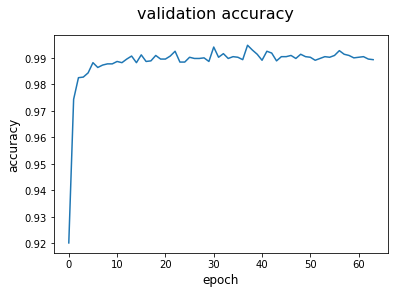

In [62]:
fig = plt.figure()
plt.plot(np.arange(len(validation_log)),validation_log, label='accuracy')
fig.suptitle('validation accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.show()


In [63]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(SESSION_FOLDER))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./train-sessions-jupyter\session
Test Accuracy = 0.985


---

## Step 3: Test Model on Random Images from Internet


### Load and Output the Images

In [64]:
def load_www_data(path, prefix):
    with open('{}/{}_www.p'.format(path, prefix), 'rb') as handle:
        www = pickle.load(handle)
    X_www, y_www = www['features'], www['labels']
    return(X_www, y_www)

X_www, y_www = load_www_data(_data_path, 'n_ea')

Number of test images: 47


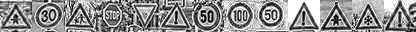

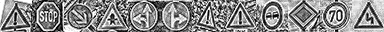

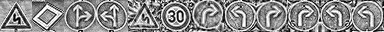

In [65]:
print('Number of test images:', len(X_www))

temp = []
for i in range(len(X_www)):
    img = X_www[i][:,:,0]
    temp.append(img)
    if i>0 and i%12==0:
        showArray(temp, concat=True, normalized=True)
        temp=[]

### Predict the Sign Type for Each Image

In [66]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./train-sessions'))
    correct, accuracy = sess.run((correct_prediction, accuracy_operation), feed_dict={x: X_www, y: y_www, enable_dropout: False})
    print("www Test Accuracy = {:.3f}".format(accuracy))
    pred_unique, pred_counts = np.unique(correct, return_counts=True)
    print('number of images:', len(X_www))
    for i_u, i_c in zip(pred_unique, pred_counts):
        if i_u:
            print('correct :', i_c)
        else:
            print('incorrect :', i_c)


INFO:tensorflow:Restoring parameters from ./train-sessions\session
www Test Accuracy = 0.936
number of images: 47
incorrect : 3
correct : 44


### Analyze Performance

In [67]:
softmax = tf.nn.softmax(logits=logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./train-sessions'))
    ce_outputs, logit_outputs = sess.run([softmax, logits], feed_dict={x: X_www, y: y_www, enable_dropout: False})
    top_k = sess.run(tf.nn.top_k(ce_outputs, k=5)) 

INFO:tensorflow:Restoring parameters from ./train-sessions\session


Output top predictions with logit values for each image.

-------------------


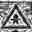

CORRECT: Right-of-way at the next intersection


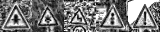

softmax probabilities:
  1.00 - Right-of-way at the next intersection
  0.00 - Beware of ice/snow
  0.00 - Double curve
  0.00 - Traffic signals
  0.00 - General caution

-------------------


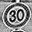

CORRECT: Speed limit (30km/h)


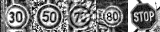

softmax probabilities:
  1.00 - Speed limit (30km/h)
  0.00 - Speed limit (50km/h)
  0.00 - Speed limit (70km/h)
  0.00 - Speed limit (80km/h)
  0.00 - Stop

-------------------


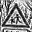

CORRECT: Children crossing


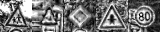

softmax probabilities:
  1.00 - Children crossing
  0.00 - Bicycles crossing
  0.00 - Priority road
  0.00 - Right-of-way at the next intersection
  0.00 - Speed limit (80km/h)

-------------------


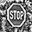

CORRECT: Stop


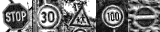

softmax probabilities:
  1.00 - Stop
  0.00 - Speed limit (30km/h)
  0.00 - Children crossing
  0.00 - Speed limit (100km/h)
  0.00 - No entry

-------------------


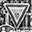

CORRECT: Yield


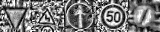

softmax probabilities:
  1.00 - Yield
  0.00 - Double curve
  0.00 - Ahead only
  0.00 - Speed limit (50km/h)
  0.00 - End of all speed and passing limits

-------------------


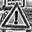

CORRECT: General caution


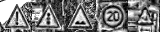

softmax probabilities:
  1.00 - General caution
  0.00 - Traffic signals
  0.00 - Bumpy road
  0.00 - Speed limit (20km/h)
  0.00 - Bicycles crossing

-------------------


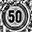

CORRECT: Speed limit (50km/h)


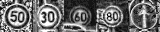

softmax probabilities:
  1.00 - Speed limit (50km/h)
  0.00 - Speed limit (30km/h)
  0.00 - Speed limit (60km/h)
  0.00 - Speed limit (80km/h)
  0.00 - Ahead only

-------------------


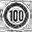

CORRECT: Speed limit (100km/h)


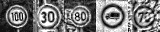

softmax probabilities:
  1.00 - Speed limit (100km/h)
  0.00 - Speed limit (30km/h)
  0.00 - Speed limit (80km/h)
  0.00 - Vehicles over 3.5 metric tons prohibited
  0.00 - Speed limit (70km/h)

-------------------


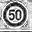

CORRECT: Speed limit (50km/h)


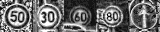

softmax probabilities:
  1.00 - Speed limit (50km/h)
  0.00 - Speed limit (30km/h)
  0.00 - Speed limit (60km/h)
  0.00 - Speed limit (80km/h)
  0.00 - Ahead only

-------------------


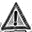

CORRECT: General caution


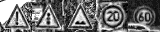

softmax probabilities:
  1.00 - General caution
  0.00 - Traffic signals
  0.00 - Bumpy road
  0.00 - Speed limit (20km/h)
  0.00 - Speed limit (60km/h)

-------------------


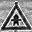

CORRECT: Right-of-way at the next intersection


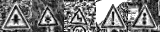

softmax probabilities:
  1.00 - Right-of-way at the next intersection
  0.00 - Beware of ice/snow
  0.00 - Double curve
  0.00 - General caution
  0.00 - Traffic signals

-------------------


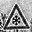

CORRECT: Beware of ice/snow


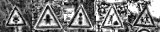

softmax probabilities:
  0.24 - Beware of ice/snow
  0.23 - Right-of-way at the next intersection
  0.06 - Traffic signals
  0.05 - Road work
  0.05 - Children crossing

-------------------


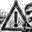

CORRECT: General caution


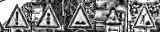

softmax probabilities:
  1.00 - General caution
  0.00 - Traffic signals
  0.00 - Bumpy road
  0.00 - Bicycles crossing
  0.00 - Road work

-------------------


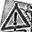

CORRECT: General caution


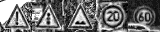

softmax probabilities:
  1.00 - General caution
  0.00 - Traffic signals
  0.00 - Bumpy road
  0.00 - Speed limit (20km/h)
  0.00 - Speed limit (60km/h)

-------------------


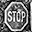

CORRECT: Stop


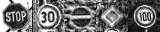

softmax probabilities:
  1.00 - Stop
  0.00 - Speed limit (30km/h)
  0.00 - No entry
  0.00 - Priority road
  0.00 - Speed limit (100km/h)

-------------------


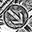

CORRECT: Keep right


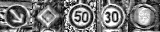

softmax probabilities:
  0.98 - Keep right
  0.02 - Priority road
  0.00 - Speed limit (50km/h)
  0.00 - Speed limit (30km/h)
  0.00 - No vehicles

-------------------


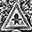

CORRECT: Right-of-way at the next intersection


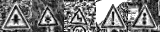

softmax probabilities:
  1.00 - Right-of-way at the next intersection
  0.00 - Beware of ice/snow
  0.00 - Double curve
  0.00 - General caution
  0.00 - Traffic signals

-------------------


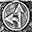

CORRECT: Go straight or left


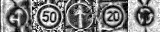

softmax probabilities:
  1.00 - Go straight or left
  0.00 - Speed limit (50km/h)
  0.00 - Ahead only
  0.00 - Speed limit (20km/h)
  0.00 - Roundabout mandatory

-------------------


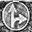

CORRECT: Go straight or right


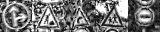

softmax probabilities:
  1.00 - Go straight or right
  0.00 - Road work
  0.00 - Dangerous curve to the right
  0.00 - Children crossing
  0.00 - No passing

-------------------


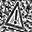

CORRECT: General caution


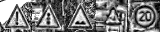

softmax probabilities:
  1.00 - General caution
  0.00 - Traffic signals
  0.00 - Bumpy road
  0.00 - Bicycles crossing
  0.00 - Speed limit (20km/h)

-------------------


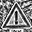

CORRECT: General caution


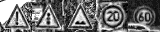

softmax probabilities:
  1.00 - General caution
  0.00 - Traffic signals
  0.00 - Bumpy road
  0.00 - Speed limit (20km/h)
  0.00 - Speed limit (60km/h)

-------------------


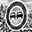

CORRECT: No passing


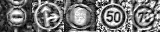

softmax probabilities:
  1.00 - No passing
  0.00 - Go straight or right
  0.00 - No vehicles
  0.00 - Speed limit (50km/h)
  0.00 - Speed limit (70km/h)

-------------------


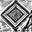

CORRECT: Priority road


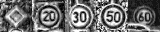

softmax probabilities:
  1.00 - Priority road
  0.00 - Speed limit (20km/h)
  0.00 - Speed limit (30km/h)
  0.00 - Speed limit (50km/h)
  0.00 - Speed limit (60km/h)

-------------------


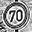

CORRECT: Speed limit (70km/h)


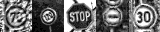

softmax probabilities:
  1.00 - Speed limit (70km/h)
  0.00 - Speed limit (120km/h)
  0.00 - Stop
  0.00 - No passing
  0.00 - Speed limit (30km/h)

-------------------


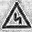

CORRECT: Double curve


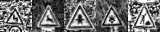

softmax probabilities:
  1.00 - Double curve
  0.00 - Wild animals crossing
  0.00 - Right-of-way at the next intersection
  0.00 - Beware of ice/snow
  0.00 - Road work

-------------------


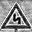

INCORRECT: Bicycles crossing - should be: Double curve


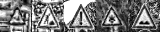

softmax probabilities:
  0.80 - Bicycles crossing
  0.07 - Road work
  0.02 - General caution
  0.01 - Beware of ice/snow
  0.01 - Bumpy road

-------------------


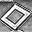

CORRECT: Priority road


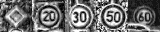

softmax probabilities:
  1.00 - Priority road
  0.00 - Speed limit (20km/h)
  0.00 - Speed limit (30km/h)
  0.00 - Speed limit (50km/h)
  0.00 - Speed limit (60km/h)

-------------------


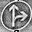

CORRECT: Go straight or right


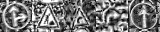

softmax probabilities:
  1.00 - Go straight or right
  0.00 - Road work
  0.00 - Dangerous curve to the right
  0.00 - Turn right ahead
  0.00 - Ahead only

-------------------


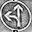

CORRECT: Go straight or left


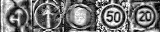

softmax probabilities:
  0.99 - Go straight or left
  0.00 - Ahead only
  0.00 - No vehicles
  0.00 - Speed limit (50km/h)
  0.00 - Speed limit (20km/h)

-------------------


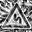

CORRECT: Double curve


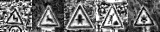

softmax probabilities:
  1.00 - Double curve
  0.00 - Wild animals crossing
  0.00 - Right-of-way at the next intersection
  0.00 - Road work
  0.00 - Beware of ice/snow

-------------------


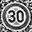

CORRECT: Speed limit (30km/h)


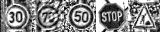

softmax probabilities:
  1.00 - Speed limit (30km/h)
  0.00 - Speed limit (70km/h)
  0.00 - Speed limit (50km/h)
  0.00 - Stop
  0.00 - Road work

-------------------


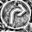

CORRECT: Turn right ahead


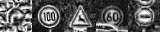

softmax probabilities:
  1.00 - Turn right ahead
  0.00 - Speed limit (100km/h)
  0.00 - Wild animals crossing
  0.00 - Speed limit (60km/h)
  0.00 - No passing

-------------------


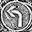

CORRECT: Turn left ahead


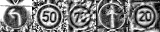

softmax probabilities:
  1.00 - Turn left ahead
  0.00 - Speed limit (50km/h)
  0.00 - Speed limit (70km/h)
  0.00 - Ahead only
  0.00 - Speed limit (20km/h)

-------------------


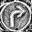

CORRECT: Turn right ahead


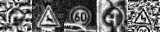

softmax probabilities:
  1.00 - Turn right ahead
  0.00 - Wild animals crossing
  0.00 - Speed limit (60km/h)
  0.00 - Go straight or left
  0.00 - Double curve

-------------------


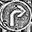

CORRECT: Turn right ahead


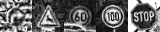

softmax probabilities:
  1.00 - Turn right ahead
  0.00 - Wild animals crossing
  0.00 - Speed limit (60km/h)
  0.00 - Speed limit (100km/h)
  0.00 - Stop

-------------------


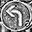

CORRECT: Turn left ahead


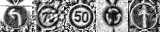

softmax probabilities:
  0.97 - Turn left ahead
  0.01 - Speed limit (70km/h)
  0.01 - Speed limit (50km/h)
  0.00 - Roundabout mandatory
  0.00 - Ahead only

-------------------


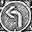

INCORRECT: No vehicles - should be: Turn left ahead


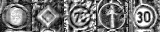

softmax probabilities:
  0.71 - No vehicles
  0.12 - Priority road
  0.10 - Speed limit (70km/h)
  0.02 - Ahead only
  0.02 - Speed limit (30km/h)

-------------------


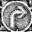

CORRECT: Turn right ahead


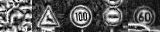

softmax probabilities:
  1.00 - Turn right ahead
  0.00 - Wild animals crossing
  0.00 - Speed limit (100km/h)
  0.00 - No passing
  0.00 - Speed limit (60km/h)

-------------------


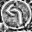

INCORRECT: Speed limit (50km/h) - should be: Turn left ahead


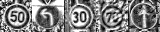

softmax probabilities:
  0.99 - Speed limit (50km/h)
  0.00 - Turn left ahead
  0.00 - Speed limit (30km/h)
  0.00 - Speed limit (70km/h)
  0.00 - Ahead only

-------------------


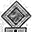

CORRECT: Priority road


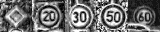

softmax probabilities:
  1.00 - Priority road
  0.00 - Speed limit (20km/h)
  0.00 - Speed limit (30km/h)
  0.00 - Speed limit (50km/h)
  0.00 - Speed limit (60km/h)

-------------------


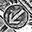

CORRECT: Keep left


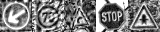

softmax probabilities:
  1.00 - Keep left
  0.00 - Speed limit (70km/h)
  0.00 - Dangerous curve to the right
  0.00 - Stop
  0.00 - Right-of-way at the next intersection

-------------------


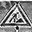

CORRECT: Road work


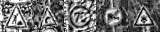

softmax probabilities:
  1.00 - Road work
  0.00 - Dangerous curve to the right
  0.00 - Speed limit (70km/h)
  0.00 - End of no passing by vehicles over 3.5 metric tons
  0.00 - Beware of ice/snow

-------------------


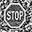

CORRECT: Stop


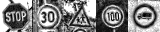

softmax probabilities:
  1.00 - Stop
  0.00 - Speed limit (30km/h)
  0.00 - Children crossing
  0.00 - Speed limit (100km/h)
  0.00 - Vehicles over 3.5 metric tons prohibited

-------------------


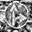

CORRECT: Go straight or right


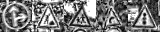

softmax probabilities:
  1.00 - Go straight or right
  0.00 - Road work
  0.00 - Children crossing
  0.00 - Dangerous curve to the right
  0.00 - Traffic signals

-------------------


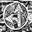

CORRECT: Go straight or left


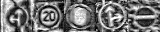

softmax probabilities:
  1.00 - Go straight or left
  0.00 - Speed limit (20km/h)
  0.00 - No vehicles
  0.00 - Go straight or right
  0.00 - No entry

-------------------


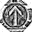

CORRECT: Ahead only


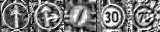

softmax probabilities:
  1.00 - Ahead only
  0.00 - Go straight or right
  0.00 - End of all speed and passing limits
  0.00 - Speed limit (30km/h)
  0.00 - Speed limit (70km/h)

-------------------


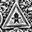

CORRECT: Right-of-way at the next intersection


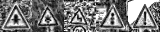

softmax probabilities:
  1.00 - Right-of-way at the next intersection
  0.00 - Beware of ice/snow
  0.00 - Double curve
  0.00 - Traffic signals
  0.00 - General caution



In [114]:
classes_id, classes_first_index, classes_count = np.unique(y_test, return_counts=True, return_index=True)

for i in range(len(X_www)):
    print('-------------------')
    i_class = y_www[i]
    i_tk = top_k.values[i]
    i_ti = top_k.indices[i]
    showArray(X_www[i][:,:,0],normalized=True)
    if i_class==i_ti[0]:
        print('CORRECT:',sign_names[i_ti[0]])
    else:
        print('INCORRECT:',sign_names[i_ti[0]],'- should be:',sign_names[i_class])
    temp=[]
    temp_logits='softmax probabilities:\n'
    for o_tk,o_ti in zip(i_tk,i_ti):
        temp.append(X_test[classes_first_index[o_ti]][:,:,0])
        temp_logits += "  {1:.2f} - {0}\n".format(sign_names[o_ti], o_tk)
    showArray(temp, concat=True, normalized=True)
    print(temp_logits)




## Step 4 (Optional): Visualize the Neural Network's State with Test Images


INFO:tensorflow:Restoring parameters from ./train-sessions-jupyter\session


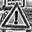

tensor: Tensor("cr1/Relu:0", shape=(?, 32, 32, 64), dtype=float32)
activation shape: (1, 32, 32, 64)
activation featuremap value range: 0 1.22334


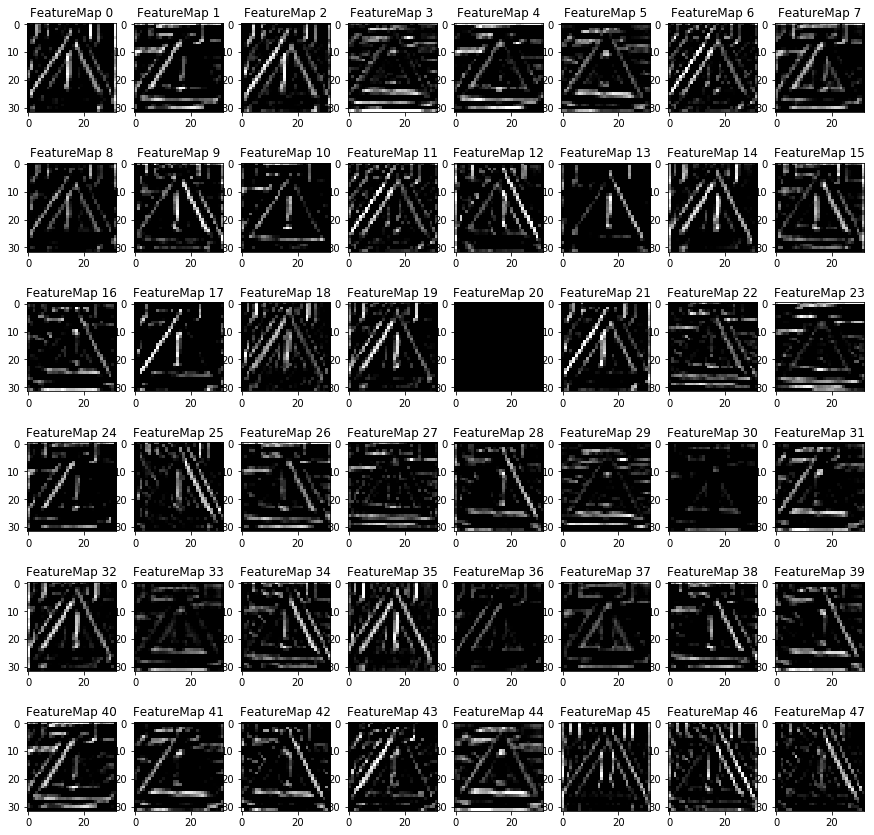

In [118]:
### Visualize your network's feature maps here.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(sess, image_input, tf_activation, activation_min=-111, activation_max=-111,calculate_minmax=False,plt_num=1,enhance=False):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    print('tensor:', tf_activation)
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, enable_dropout: False})
    print('activation shape:',activation.shape)
    featuremaps = activation.shape[-1]
    
    a_min = 0
    a_max = 0
    for featuremap in range(featuremaps):
        a_min = min(a_min, np.min(activation[0,:,:, featuremap]))
        a_max = max(a_max, np.max(activation[0,:,:, featuremap]))
    print('activation featuremap value range:',a_min,a_max)
    
    if not calculate_minmax:
        if activation_min>-100:
            a_min=activation_min
        if activation_max>-100:
            a_max=activation_max
        
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(min(48,featuremaps)):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if enhance:
            plt.imshow(np.sqrt(activation[0,:,:, featuremap]), interpolation="nearest", vmin=a_min, vmax=a_max, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=a_min, vmax=a_max, cmap="gray")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(SESSION_FOLDER))
    for i in [n.name for n in tf.get_default_graph().as_graph_def().node]:
        continue
        print(i)
    
    #t = sess.graph.get_tensor_by_name('cr1/Conv2D:0')
    t = sess.graph.get_tensor_by_name('cr1/Relu:0')
    #t = sess.graph.get_tensor_by_name('cr2/Conv2D:0')
    #t = sess.graph.get_tensor_by_name('cr2/Relu:0')
    #t = sess.graph.get_tensor_by_name('cr3/Relu:0')
    #t = sess.graph.get_tensor_by_name('cr4/Relu:0')
    img = X_www[5]
    showArray(img[:,:,0], normalized=True)
    outputFeatureMap(sess, [img], t, activation_min=0, activation_max=0.7, enhance=False)
    plt.show()